# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
pip install palmerpenguins

Note: you may need to restart the kernel to use updated packages.


In [2]:
from palmerpenguins import load_penguins

penguins = load_penguins()
penguins = penguins.dropna()

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *  
import pandas as pd
from plotnine import *

y = penguins["species"]
X = penguins.drop(columns=["species"])

cat_cols = ["island", "sex"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

knn3 = make_pipeline(preprocess, KNeighborsClassifier(n_neighbors=3))
knn7 = make_pipeline(preprocess, KNeighborsClassifier(n_neighbors=7))

knn3.fit(X_train, y_train)
knn7.fit(X_train, y_train)

pred_knn3 = knn3.predict(X_test)
pred_knn7 = knn7.predict(X_test)

tree3 = make_pipeline(preprocess, DecisionTreeClassifier(max_depth=3, random_state=42))
tree6 = make_pipeline(preprocess, DecisionTreeClassifier(max_depth=6, random_state=42))

tree3.fit(X_train, y_train)
tree6.fit(X_train, y_train)

pred_tree3 = tree3.predict(X_test)
pred_tree6 = tree6.predict(X_test)

In [4]:
def evaluate(name, y_pred, model):
    print(name)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    y_prob = model.predict_proba(X_test)
    auc = roc_auc_score(pd.get_dummies(y_test), y_prob, multi_class="ovr")
    print("AUC:", auc)

evaluate("KNN (k=3)", pred_knn3, knn3)
evaluate("KNN (k=7)", pred_knn7, knn7)
evaluate("Tree (depth=3)", pred_tree3, tree3)
evaluate("Tree (depth=6)", pred_tree6, tree6)

KNN (k=3)
Confusion Matrix:
 [[36  1  0]
 [ 1 16  0]
 [ 0  0 30]]
Accuracy: 0.9761904761904762
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        37
   Chinstrap       0.94      0.94      0.94        17
      Gentoo       1.00      1.00      1.00        30

    accuracy                           0.98        84
   macro avg       0.97      0.97      0.97        84
weighted avg       0.98      0.98      0.98        84

AUC: 0.9995156645820722
KNN (k=7)
Confusion Matrix:
 [[37  0  0]
 [ 0 17  0]
 [ 0  0 30]]
Accuracy: 1.0
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        37
   Chinstrap       1.00      1.00      1.00        17
      Gentoo       1.00      1.00      1.00        30

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

AUC: 1.0
Tree (depth=3)
Confusion Matri

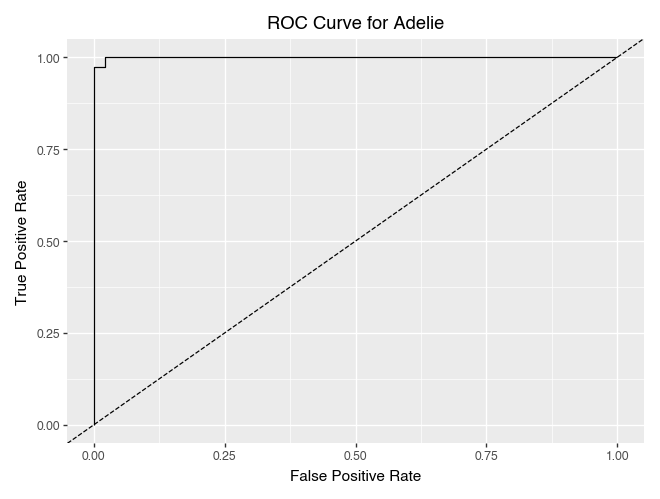

In [ ]:
species_choice = "Adelie"

y_test_bin = (y_test == species_choice).astype(int)
prob = knn3.predict_proba(X_test)[:, list(knn3.classes_).index(species_choice)]

fpr, tpr, _ = roc_curve(y_test_bin, prob)
roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr})

# Plot ROC
(
    ggplot(roc_df, aes("fpr", "tpr"))
    + geom_line()
    + geom_abline(linetype="dashed")  # diagonal reference line
    + labs(title=f"ROC Curve for {species_choice}", x="False Positive Rate", y="True Positive Rate")
)
